In [1]:
import os

IMG_PATH = "_img"
CACHE_PATH = "_cache"
if not os.path.isdir(IMG_PATH): os.mkdir(IMG_PATH)
if not os.path.isdir(CACHE_PATH): os.mkdir(CACHE_PATH)

import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde

from tqdm import tqdm
import pickle
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as u
from astropy.constants.si import L_sun

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.patches as  mpatches
import seaborn as sns

sns.set_theme(context="talk", style="ticks", palette="colorblind", color_codes=True)

from MaStarChecks.io import load_libraries
from MaStarChecks.constants import MASTAR_GAIA_PATH
from MaStarChecks.plotting.styles import *


PROCESSED_PATH = "../fitting/_data/processed-libraries-v3.1.2"

LABELS = ("MaStar",)
Y_COLUMNS = ["TEFF", "LOGG", "MET", "ALPHAM"]

def get_range(x, data=None, n=2):
    if data is None:
        xmin, xmax = x.min(), x.max()
    else:
        xmin, xmax = data[x].min(), data[x].max()
    return np.linspace(xmin, xmax, n)

In [2]:
spectra, catalogues = load_libraries(labels=LABELS,
                                    libraries_path=PROCESSED_PATH, use_cache=False,
                                    cache_path=CACHE_PATH, cache_label="cleaned-v2")

100%|##################################################| reading FITS for MaStar: 20332/20332 [03:27<00:00, 97.82FITS/s] 
100%|##################################################| extracting MaStar catalogue: 20332/20332 [00:27<00:00, 744.39record/s]
100%|##################################################| extracting FLUX from MaStar: 20332/20332 [00:06<00:00, 3341.92SED/s]


In [3]:
spectra_mastar = spectra["MaStar"]["FLUX"]
catalogue_mastar = catalogues["MaStar"]

In [4]:
match_fits = fits.open(MASTAR_GAIA_PATH)

match_columns = ["MANGAID", "SOURCE_ID", "RA", "DEC", "PARALLAX", "R_EST", "PHOT_G_MEAN_MAG", "BP_RP"]
match_mastar_gaia = Table(match_fits[1].data)[match_columns].to_pandas()
match_mastar_gaia = match_mastar_gaia.rename(columns=lambda s:s.lower())
match_mastar_gaia = match_mastar_gaia.rename(columns={"mangaid":"ID"})

match_mastar_gaia.ID = match_mastar_gaia.ID.str.strip()
match_mastar_gaia = match_mastar_gaia.loc[match_mastar_gaia.ID.isin(catalogue_mastar.ID)].reset_index(drop=True)
# match_mastar_gaia = match_mastar_gaia.mask((match_mastar_gaia==-999).any(axis="columns"))
match_mastar_gaia["g"] = match_mastar_gaia.phot_g_mean_mag - 5*np.log10(match_mastar_gaia.r_est) + 5
match_mastar_gaia["d"] = match_mastar_gaia.r_est
# match_mastar_gaia

In [5]:
catalogue_gaia = pd.read_csv("_data/gaia-catalogue-clean.csv", index_col="source_id")
catalogue_gaia["g"] = catalogue_gaia.phot_g_mean_mag + 5*np.log10(catalogue_gaia.parallax) - 10
catalogue_gaia["d"] = 1000 / catalogue_gaia.parallax
# catalogue_gaia

/home/mejia/.cache/pypoetry/virtualenvs/mastar-checks-RQnjUWan-py3.8/lib/python3.8/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [6]:
# plt.figure(figsize=(10,10))

# (catalogue_gaia.parallax).hist(range=(0,10), bins=70, density=True, histtype="stepfilled", hatch="////", fc="none", ec="0.7")
# (match_mastar_gaia.parallax).hist(range=(0,10), bins=70, density=True, histtype="stepfilled", lw=0, fc="lightblue", label="MaStar")
# (catalogue_gaia.parallax).hist(range=(0,10), bins=70, density=True, histtype="step", lw=2, ec="0.7", label="Gaia DR2")

# plt.grid(False)
# plt.legend(loc=1)
# plt.xlabel(r"$\varpi$ [mas]")
# plt.ylabel(r"density")

# sns.despine(trim=True)

In [7]:
cmd_columns = ["bp_rp", "g"]

cmd_gaia = catalogue_gaia.filter(items=cmd_columns).dropna()
cmd_mastar = match_mastar_gaia.filter(items=cmd_columns).dropna()

In [8]:
# use resample method to sample the distribution instead of evaluating
# sample the GAIA data to reduce the number of points
# compute the PDF using the histogram and then interpolating in the grid of the MaStar

from scipy import interpolate

from MaStarChecks.plotting.analysis import density_scatter_hist, contours_from_pdf
from MaStarChecks.plotting.analysis import contours_from_hist


bp_rp_lims = min(cmd_gaia.bp_rp.min(), cmd_mastar.bp_rp.min()), max(cmd_gaia.bp_rp.max(), cmd_mastar.bp_rp.max())
g_lims = min(cmd_gaia.g.min(), cmd_mastar.g.min()), max(cmd_gaia.g.max(), cmd_mastar.g.max())

Z_gaia, x_e, y_e = np.histogram2d(cmd_gaia.bp_rp, cmd_gaia.g, bins=100, range=(bp_rp_lims,g_lims), density=False)
Z_mastar, _, _ = np.histogram2d(cmd_mastar.bp_rp, cmd_mastar.g, bins=100, range=(bp_rp_lims,g_lims), density=False)

xi, yi = 0.5*(x_e[:-1]+x_e[1:]), 0.5*(y_e[:-1]+y_e[1:])
X, Y = np.meshgrid(xi, yi)

In [9]:
gaia_cmd_pdf = interpolate.Rbf(X, Y, Z_gaia.T, function="multiquadric")
mastar_cmd_pdf = interpolate.Rbf(X, Y, Z_mastar.T, function="multiquadric")

In [11]:
vol_correction = pd.DataFrame(index=catalogue_mastar.index, columns=["ID", "RECORD","VCORR"])
vol_correction.ID = catalogue_mastar.ID
vol_correction.RECORD = catalogue_mastar.RECORD
vol_correction.VCORR = gaia_cmd_pdf(cmd_mastar.bp_rp,cmd_mastar.g) / mastar_cmd_pdf(cmd_mastar.bp_rp,cmd_mastar.g)
vol_correction.VCORR.loc[vol_correction.VCORR.values<0] = 0.0
vol_correction.VCORR /= vol_correction.VCORR.sum()

/home/mejia/.cache/pypoetry/virtualenvs/mastar-checks-RQnjUWan-py3.8/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [12]:
REWRITE = True

if REWRITE:
    for idx, r in tqdm(catalogue_mastar.iterrows(), total=catalogue_mastar.index.size, desc="updating mastar FITS", unit="FITS", ascii=True):
        fitsname = f"processed-mastar-{r.ID}-{r.RECORD}.fits.gz"
        fitspath = os.path.join(PROCESSED_PATH, fitsname)
        f = fits.open(fitspath, mode="update")

        f[0].header.set("VCORR", vol_correction.loc[idx, "VCORR"])
        f.writeto(fitspath, overwrite=True)

updating mastar FITS: 100%|##########| 20332/20332 [07:38<00:00, 44.37FITS/s]


In [13]:
MASTAR_GAIA_COORDS = os.path.join(CACHE_PATH, "mastar-gaia-coords.pk")

if REWRITE or not os.path.isfile(MASTAR_GAIA_COORDS):
    mastar_coords = SkyCoord(ra=catalogue_mastar.RA, dec=catalogue_mastar.DEC, distance=catalogue_mastar.DIST*u.kpc)
    gaia_coords = SkyCoord(ra=catalogue_gaia.ra.values*u.deg, dec=catalogue_gaia.dec.values*u.deg, distance=(catalogue_gaia.d.values/1000)*u.kpc)

    pickle.dump((mastar_coords, gaia_coords), open(MASTAR_GAIA_COORDS, "wb"))
else:
    mastar_coords, gaia_coords = pickle.load(open(MASTAR_GAIA_COORDS, "rb"))

In [14]:
mastar_ra, mastar_de = mastar_coords.ra.wrap_at("180d").rad, mastar_coords.dec.rad
gaia_ra, gaia_de = gaia_coords.ra.wrap_at("180d").rad, gaia_coords.dec.rad

mastar_R = mastar_coords.galactic.distance.value * np.cos(mastar_coords.galactic.l.value*np.pi/180) + 8
mastar_z = mastar_coords.galactic.distance.value * np.sin(mastar_coords.galactic.b.value*np.pi/180)
gaia_R = gaia_coords.galactic.distance.value * np.cos(gaia_coords.galactic.l.value*np.pi/180) + 8
gaia_z = gaia_coords.galactic.distance.value * np.sin(gaia_coords.galactic.b.value*np.pi/180)

In [15]:
# fig = plt.figure(figsize=(14,7))
# gs = GridSpec(7, 3, figure=fig)

# ax1 = fig.add_subplot(gs[:4, :-1], projection="mollweide")
# ax2 = fig.add_subplot(gs[:4, -1])

# plane_l, plane_b = np.linspace(0, 360, 2000), np.zeros(2000)
# plane_eq = SkyCoord(plane_l*u.deg, plane_b*u.deg, frame="galactic").icrs
# plane_ra = plane_eq.ra.wrap_at("180d").rad
# plane_de = plane_eq.dec.rad

# # ax1.plot(plane_ra, plane_de, ".", color="w", mew=0, ms=2, zorder=1)
# sns.histplot(x=gaia_ra, y=gaia_de, bins=300, color=GAIA_COLOR, ax=ax1, zorder=-2)
# ax1.scatter(mastar_ra, mastar_de, s=1, lw=0, c=MASTAR_COLOR, zorder=-1)
# ax1.grid(True, lw=1, ls=":", zorder=0)
# ax1.set_xlabel("RA (deg)")
# ax1.set_ylabel("DEC (deg)")

# plt.draw()
# [t.set_text(r"\textbf{%s}"%t.get_text()) for t in ax1.get_xticklabels()]
# ax1.set_xticklabels(ax1.get_xticklabels(), size="x-small")

# # sns.histplot(x=gaia_R, y=gaia_z, bins=300, color=GAIA_COLOR, ax=ax2)
# # sns.histplot(x=mastar_R, y=mastar_z, bins=300, color=MASTAR_COLOR, ax=ax2)
# ax2.scatter(gaia_R, gaia_z, s=7, lw=0, c=GAIA_COLOR)
# ax2.scatter(mastar_R, mastar_z, s=1, lw=0, c=MASTAR_COLOR)
# ax2.set_xlabel("$R$ (kpc)")
# ax2.set_ylabel("$z$ (kpc)")

# fig.tight_layout()
# fig.savefig("_img/spatial-distribution.png", bbox_inches="tight")

In [16]:
from mw_plot import center_radec, anti_center_radec, northpole_radec, southpole_radec  # constants
from mw_plot import mw_radec # milkyway plane in RA/DEC

center_radec  # refers to the [RA, DEC] of galactic center in deg
anti_center_radec  # refers to the [RA, DEC] of galactic anti-center in deg
northpole_radec  # refers to the [RA, DEC] of galactic north pole in deg
southpole_radec  # refers to the [RA, DEC] of galactic south pole in deg

mw_plane_ra, mw_plane_dec = mw_radec(deg=True)  # RA/DEC arrays of milkyway plane

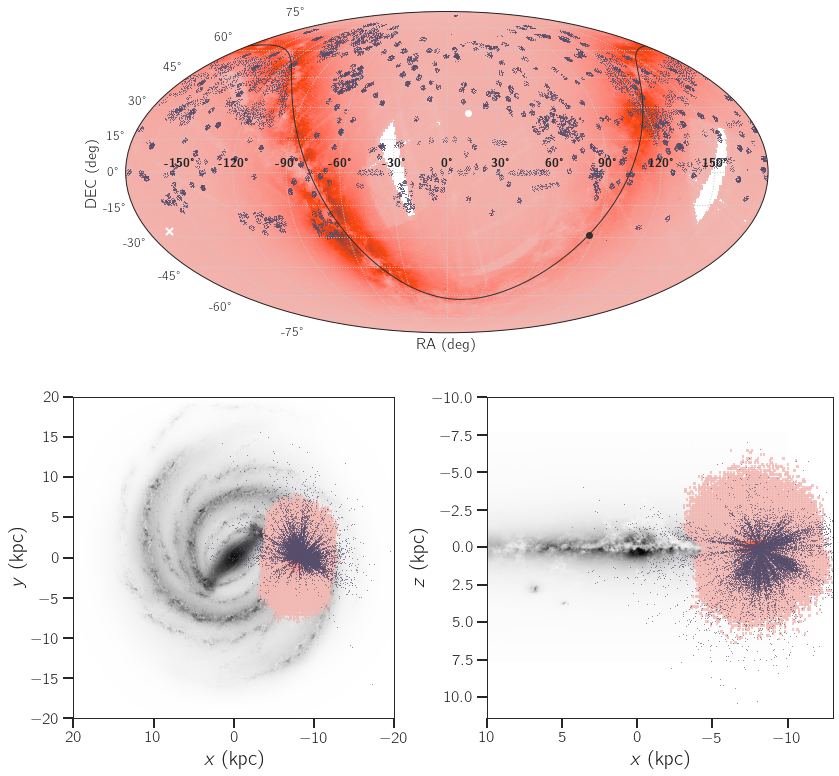

In [17]:
from astropy import units as  u
from mw_plot import MWSkyMap, MWPlot

# mw_sky = MWSkyMap(grayscale=True)
mw_xy = MWPlot(radius=20*u.kpc, unit=u.kpc, coord='galactocentric', annotation=False, grayscale=True)
mw_xz = MWPlot(radius=10*u.kpc, mode="edge-on", unit=u.kpc, coord='galactocentric', annotation=False, grayscale=True)

fig = plt.figure(figsize=(14,13))
ax1 = fig.add_subplot(211, projection="mollweide")
ax2 = fig.add_subplot(223)
ax3 = fig.add_subplot(224)

# mw_sky.transform(ax1)
mw_xy.transform(ax2)
mw_xz.transform(ax3)

ax1.plot((mw_plane_ra-180)*np.pi/180, mw_plane_dec*np.pi/180, "-", lw=1, color="#333030")
ax1.plot((center_radec[0]-180)*np.pi/180, center_radec[1]*np.pi/180, "o", color="#333030")
# ax1.plot((anti_center_radec[0]-180)*np.pi/180, anti_center_radec[1]*np.pi/180, "x", color="#333030", mew=2, mfc="none")
ax1.plot((northpole_radec[0]-180)*np.pi/180, northpole_radec[1]*np.pi/180, "ow")
ax1.plot((southpole_radec[0]-180)*np.pi/180, southpole_radec[1]*np.pi/180, "xw", mew=2, mfc="none")

sns.histplot(x=gaia_ra, y=-gaia_de, bins=300, color=GAIA_COLOR, ax=ax1, zorder=-2)
ax1.scatter(mastar_ra, mastar_de, s=1, lw=0, c=MASTAR_COLOR, zorder=-1)
ax1.grid(True, lw=1, ls=":", zorder=0)
ax1.set_xlabel("RA (deg)")
ax1.set_ylabel("DEC (deg)")

plt.draw()
[t.set_text(r"\textbf{%s}"%t.get_text()) for t in ax1.get_xticklabels()]
ax1.set_xticklabels(ax1.get_xticklabels(), size="x-small")

sns.histplot(x=gaia_coords.galactocentric.x, y=gaia_coords.galactocentric.y, bins=100, color=GAIA_COLOR, ax=ax2, alpha=0.8)
ax2.scatter(mastar_coords.galactocentric.x, mastar_coords.galactocentric.y, c=MASTAR_COLOR, lw=0, s=1, alpha=0.8)
sns.histplot(x=gaia_coords.galactocentric.x, y=gaia_coords.galactocentric.z, bins=100, color=GAIA_COLOR, ax=ax3, alpha=0.8)
ax3.scatter(mastar_coords.galactocentric.x, mastar_coords.galactocentric.z, c=MASTAR_COLOR, lw=0, s=1, alpha=0.8)

ax2.set_xlabel(r"$x$ (kpc)")
ax2.set_ylabel(r"$y$ (kpc)")
ax2.set_xlim(20,-20)
ax3.set_xlabel(r"$x$ (kpc)")
ax3.set_ylabel(r"$z$ (kpc)")
ax3.set_xlim(10,-13)

fig.savefig("_img/spatial-distribution.png", bbox_inches="tight")

<ipython-input-18-690f10abefc6>:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


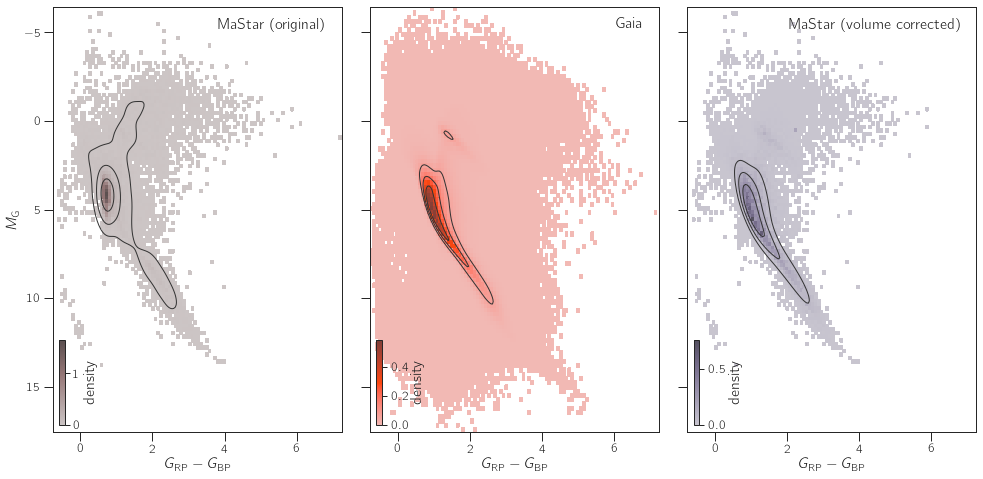

In [18]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


fig, (ax2,ax3,ax4) = plt.subplots(1, 3, figsize=(14,7), sharex=True, sharey=True)

ax2.set_xlim(bp_rp_lims)
ax2.set_ylim(g_lims[::-1])

cax2 = inset_axes(ax2, width="2%", height="20%", loc='lower left')
cax2.tick_params(length=5, labelsize="x-small")
sns.histplot(
    data=cmd_mastar.rename(columns={"bp_rp":r"$G_{\mathrm{RP}}-G_{\mathrm{BP}}$", "g":r"$M_{\mathrm{G}}$"}),
    x=r"$G_{\mathrm{RP}}-G_{\mathrm{BP}}$", y=r"$M_{\mathrm{G}}$", bins=100, stat="density", color=LIGHT_COLOR, ax=ax2, cbar=True, cbar_ax=cax2, cbar_kws={"label":"density"}
)
sns.kdeplot(
    data=cmd_mastar.rename(columns={"bp_rp":r"$G_{\mathrm{RP}}-G_{\mathrm{BP}}$", "g":r"$M_{\mathrm{G}}$"}),
    x=r"$G_{\mathrm{RP}}-G_{\mathrm{BP}}$", y=r"$M_{\mathrm{G}}$", levels=[0.25,0.50,0.75], linewidths=1, color="0.2", ax=ax2
)
ax2.text(0.95, 0.95, "MaStar (original)", transform=ax2.transAxes, ha="right", size="small")

cax3 = inset_axes(ax3, width="2%", height="20%", loc='lower left')
cax3.tick_params(length=5, labelsize="x-small")
sns.histplot(
    data=cmd_gaia.rename(columns={"bp_rp":r"$G_{\mathrm{RP}}-G_{\mathrm{BP}}$", "g":r"$M_{\mathrm{G}}$"}),
    x=r"$G_{\mathrm{RP}}-G_{\mathrm{BP}}$", y=r"$M_{\mathrm{G}}$", bins=100, stat="density", color=GAIA_COLOR, ax=ax3, cbar=True, cbar_ax=cax3, cbar_kws={"label":"density"}
)
sns.kdeplot(
    data=cmd_gaia.rename(columns={"bp_rp":r"$G_{\mathrm{RP}}-G_{\mathrm{BP}}$", "g":r"$M_{\mathrm{G}}$"}),
    x=r"$G_{\mathrm{RP}}-G_{\mathrm{BP}}$", y=r"$M_{\mathrm{G}}$", levels=[0.25,0.50,0.75], linewidths=1, color="0.2", ax=ax3
)
ax3.text(0.95, 0.95, "Gaia", transform=ax3.transAxes, ha="right", size="small")

cax4 = inset_axes(ax4, width="2%", height="20%", loc='lower left')
cax4.tick_params(length=5, labelsize="x-small")
sns.histplot(
    data=cmd_mastar.rename(columns={"bp_rp":r"$G_{\mathrm{RP}}-G_{\mathrm{BP}}$", "g":r"$M_{\mathrm{G}}$"}),
    x=r"$G_{\mathrm{RP}}-G_{\mathrm{BP}}$", y=r"$M_{\mathrm{G}}$", weights=vol_correction.VCORR, bins=100, stat="density", color=MASTAR_COLOR, ax=ax4, cbar=True, cbar_ax=cax4, cbar_kws={"label":"density"}
)
sns.kdeplot(
    data=cmd_mastar.rename(columns={"bp_rp":r"$G_{\mathrm{RP}}-G_{\mathrm{BP}}$", "g":r"$M_{\mathrm{G}}$"}),
    x=r"$G_{\mathrm{RP}}-G_{\mathrm{BP}}$", y=r"$M_{\mathrm{G}}$", weights=vol_correction.VCORR, levels=[0.25,0.50,0.75], linewidths=1, color="0.2", ax=ax4
)
ax4.text(0.95, 0.95, "MaStar (volume corrected)", transform=ax4.transAxes, ha="right", size="small")

plt.tight_layout()
plt.savefig("_img/cmd-vcorrection.png", bbox_inches="tight")